# Förderhinweis

Dieses Dokument ist Teil des Lehrmaterials für die Fortbildung zum/zur **Berufsspezialist/in KI und Maschinelles Lernen.**

Die Entwicklung und Erprobung dieses Bildungsangebotes wurde vom Bundesministerium für Bildung und Forschung im Rahmen des InnoVET-Programms gefördert.

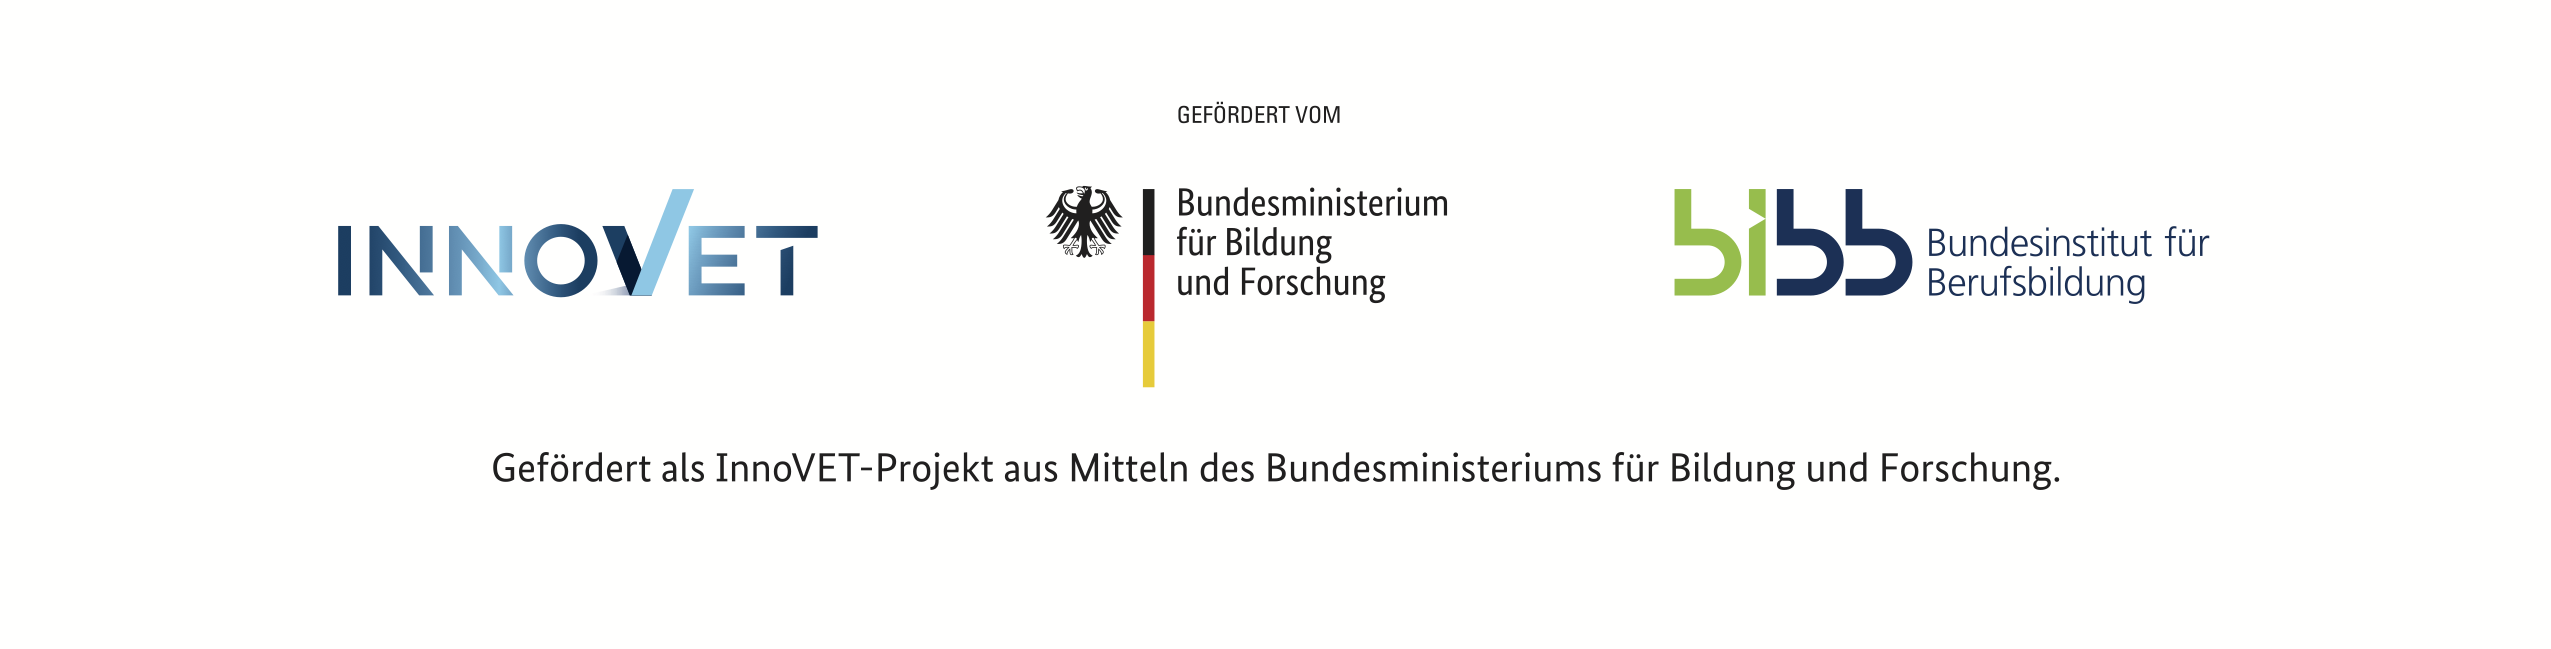

# Lizenzhinweis

Dieses Notebook "Bilderkennung mit neuronalen Netzen" wurde von Antje Schweitzer, KI B3 / Universität Stuttgart, erstellt.

Das Werk, mit Ausnahme der oben abgebildeten Förderlogos, ist lizenziert unter [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/deed.de) (Namensnennung 4.0 International)

# Ziel dieses Projekts

Bei diesem Notebook geht es darum, Objekte in Bildern zu klassifizieren, oder in anderen Worten: Objekte in Bildern zu erkennen. Für **Bilderkennung** werden typischerweise Convolutional Neural Networks (CNNs) mit zweidimensionalen Filterkernen (2D-Filterkerne) verwendet. Dieses Projekt erweitert das Notebook zu Predictive Maintenance mit CNNs um 2D-Filterkerne.  

Das Vorgehen wird exemplarisch für Fotos von Kleidungsstücken illustriert, die auch im Notebook zu FNNs und Overfitting genutzt wurden.

Zum Training des CNNs wird auch dieses Mal die Bibliothek *Keras* als nutzerfreundliches Interface zur Deep-Learning-Bibliothek *Tensorflow* verwendet.

# Themen in diesem Notebook

* CNNs: Implementierung in tensorflow.keras
* Kompromiss aus Trainingsdauer/Modellkomplexität vs. Performanz
* Robustheit von Modellen
* Vermeidung von Overfitting
  * Data Augmentation
* Dropout bei der Evaluierung
* Trainingsdaten selbst aus Foto-Dateien erstellen
* Balancierte Trainingsdaten erstellen

# Benötigte Bibliotheken importieren

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
tf.__version__

In [ ]:
import os
import random

def set_random_state(seed_value):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.compat.v1.set_random_seed(seed_value)
    tf.random.set_seed(seed_value)

# wählen Sie hier irgendeinen Wert
# der Code weiter unten wird immer myseed als Wert für set_random_state verwenden
myseed = 42

# Daten

Wir nutzen hier wieder den Datensatz mit Fotos von Kleidungsstücken, der auch im Notebook zu FNNs und Overfitting verwendet wurde. Lesen Sie ggf. die Informationen zu den Daten dort nach.

## Daten laden

In [ ]:
# Beschreibung siehe https://keras.io/api/datasets/fashion_mnist/

fashion_mnist = tf.keras.datasets.fashion_mnist
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = fashion_mnist.load_data()

X_train_orig.shape

Wir haben nun also die Features der Trainingsdaten in der Variable X_train_orig. Der Tensor hat die Form (60000, 28, 28) - es handelt sich um 60000 Bilder mit je 28x28 Pixeln. Die dazugehörigen korrekten Klassen für die Trainingsdaten sind in y_train_orig gespeichert. Analog sind die Features der Testdaten in X_test_orig und die korrekten Klassen in y_test_orig.

## Die Daten anschauen


Wie Sie die Rohdaten ansehen können, finden Sie im vorhergehenden Notebook zu FNNs und Overfitting. Wir wiederholen hier nur noch einmal die grafische Darstellung.

Damit man nicht immer die ersten 4 Bilder ansehen muss, hatten wir die Variable `offset` eingeführt - es werden dann immer die ersten 4 Bilder ab dem Offset gezeigt - ändern Sie die Variable, um andere Bilder zu sehen.

In [ ]:
kleidungsarten = ["T-shirt", "Hose", "Pullover", "Kleid", "Mantel",
               "Sandale", "Shirt", "Turnschuh", "Tasche", "Stiefel"]

plt.figure()

# eine Reihe mit 4 Bildern
figure, panel = plt.subplots(1,4)

# Offset, um ggf. Bilder ab einem bestimmten Index anzuzeigen
offset=14

# die ersten vier Bilder in je einem Panel der Grafik anzeigen
# cmap="binary" gibt an, dass es sich um schwarz/weiß Daten handelt
for i in range(4):
    # Bild anzeigen
    panel[i].imshow(X_train_orig[i+offset], cmap="binary")
    # Titel ergänzen: y_train_orig[i+offset] ergibt die Klasse, z.B. 9
    # dann entsprechendes Element aus kleidungsarten als Titel nehmen:
    # kleidungsarten[9] ergibt Stiefel
    panel[i].title.set_text(kleidungsarten[y_train_orig[i+offset]])

## Transformation der Bilddaten
Im Original sind die Graustufen in diesen Daten als Zahlen zwischen 0 und 1 kodiert. Wir teilen hier durch 255, so dass wir anstatt Werten zwischen 0 und 255 Werte zwischen 0 und 1 bekommen. Dies verhindert, dass durch die vielen Multiplikationen beim Training zu hohe Werte entstehen.

Die Kodierung mit Werten zwischen 0 und 1 ist übrigens eine auch sonst häufig gebräuchliche Darstellung von Werten mit Graustufen.

In [ ]:
# Farbwerte normalisieren
X_train_norm = X_train_orig / 255.
X_test_norm = X_test_orig / 255.

# Variablen mit den korrekten Klassen analog zu den Trainingsdaten benennen
y_train = y_train_orig
y_test = y_test_orig

## Training- und Validations-Split

Bisher haben wir es dem Modelltraining überlassen, die Trainingsdaten noch einmal in die tatsächlichen Trainingsdaten und die zur Optimierung des Trainings verwendeten Validierungsdaten aufzuteilen (siehe dazu auch die Projekte ganz unten im Notebook zur FNNs und Overfitting). Da dabei nicht garantiert ist, dass Trainings- und Validierungsdaten die zu lernenden Klassen in gleichen Anteilen enthalten, übernehmen wir die Aufteilung dieses Mal selbst.

Wir verwenden wieder die Funktion `train_test_split` aus `sklearn` (scikit-learn). Wir geben an, dass wir 10000 der Datenpunkte zum Testen (hier also als Validierungsdaten) zurückbehalten wollen, und stellen mithilfe der Option `stratify` sicher, dass der Anteil der Klassen so sein soll wie in den ursprünglichen Trainingsdaten (also wie im Vektor `y_train` mit den Klassen-Labels). Danach haben wir in `X_train` die Features der neuen Trainingsdaten, in `X_valid` die Features der Validierungsdaten, und in `y_train` sowie `y_valid` die korrekten Labels für die neuen Trainings- und Validierungsdaten.

In [ ]:
# Training-Validation-Split, bei dem der Anteil der verschiedenen Klassen
# in beiden Teilmengen gleich wie in den Original-Trainingsdaten ist (stratify=y_train)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_norm, y_train_orig, test_size=10000, stratify=y_train_orig, random_state=143)

# Training eines ersten Modells

## Plot-Funktion definieren

Bevor wir mit dem Training von Modellen starten, definieren wir noch die bereits bekannte Funktion, mit der man den Verlauf des Trainings visualisieren kann.

In [ ]:
# Grafik mit der Entwicklung von Verlust und Accuracy im Lauf des Trainings
# eine Funktion definieren, die den gewuenschten Plot erzeugt
# braucht als Argument das Ergebnis des Trainings (der Funktion fit)
def plot_valid(history):

    # Liste der Epochen im Training, kann der Länge der Liste von Accuracy-Werten entnommen werden
    epochs = range(1,len(history.history['accuracy'])+1)

    # Liste der Accuracies auf den Trainingsdaten und auf den Validationsdaten
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    # Liste der Verlustwerte auf beiden Daten
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # als Grafik plotten
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label='Trainingsdaten')
    plt.plot(epochs, val_loss, label='Validationsdaten')
    plt.legend(loc='upper right')
    plt.title('Verlust')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label='Trainingsdaten')
    plt.plot(epochs, val_acc, label='Validationsdaten')
    plt.legend(loc='lower right')
    plt.title('Accuracy')
    plt.show()

## CNN

Wir beginnen mit einem für Bilderkennung typischen Modell: einem CNN.

Wir verwenden auch hier als Maßnahme gegen Overfitting Dropout-Schichten. Wir beginnen mit 2 Konvolutionsschichten. Im Gegensatz zu den bisher bekannten 1D-Konvolutionsschichten verwenden wir nun 2D-Konvolutionsschichten. Der Unterschied besteht darin, dass die Konvolutions-Filter nicht nur in eine Richtung verschoben werden, sondern in 2 Richtungen. Dies ist hier notwendig, weil wir Kerne mit einer Größe von 3x3 Pixeln verwenden, d.h., diese decken nicht die volle Breite bzw. Höhe der Bilder ab. Dadurch, dass wir sie in beide Richtungen verschieben, werden aber dennoch alle Bereiche der Bilder erfasst.

Hier sehen Sie eine grafische Darstellung der ersten Konvolutionsschicht, exemplarisch über einem Bild mit einem Stiefel.


![2D-Konvolution.png](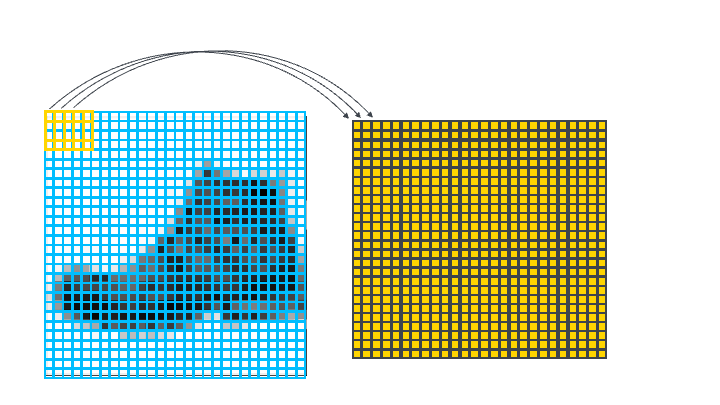
)


Die 2D-Konvolutionsschichten in Tensorflow erwarten, dass der Input mindestens 3 Dimensionen hat (z.B. 2-dimensionale Bilder mit einer weiteren Dimension für drei Farb-Kanäle mit Rot-, Blau- und Grünwerten). Wir schalten daher vor die erste Schicht noch eine Reshape-Schicht. Diese macht aus dem 2-dimensionalen Bild ein 3-dimensionales (wobei die 3. Dimension dann in unserem Fall nur aus dem einen Graustufenwert besteht). Diese Reshape-Schicht bekommt 28x28 als Input und gibt 28x28x1 als Output weiter.

Die erste Konvolutionsschicht bekommt also Input der Form 28x28x1. Wir geben als Argumente an: `Conv2D(16, 3, ...)`. Dies bedeutet, dass wir 16 Kerne verwenden wollen, die die Breite und Länge 3 haben. Dies hat den Effekt, dass wir 16 verschiedene 3x3-Kerne verwenden, die jeweils in den ersten beiden Dimensionen verschoben werden und dabei alle weiteren Dimensionen mit erfassen. In diesem Fall gibt es allerdings nicht wirklich eine weitere Dimension, da wir in dieser Dimension immer nur den einen Wert haben (Form: 28x28x1).  

Jeder Filterkern der ersten Schicht liefert damit als Output eine sogenannte Feature Map der Form 26x26 (da wir die 3x3-Kerne nur bis zum Rand der 28x28-Bilder schieben, aber nicht darüber hinaus, verlieren wir hier je 2 Werte in jeder Dimension). Da wir in der ersten Schicht 16 Kerne verwenden, bekommen wir für die gesamte Schicht also Output der Form 26x26x16. Wir haben anschließend nun wirklich drei Dimensionen - die dritte Dimension beinhaltet die 16 Kanäle mit den 16 Feature Maps. Wir brauchen für diese erste Schicht pro Filterkern 9 Gewichte sowie einen Bias, d.h. 10 Parameter pro Filterkern, und damit insgesamt 160 Parameter für diese Schicht.

Auch für die zweite Schicht verwenden wir 3x3-Filterkerne. Der Input hat hier die Form 26x26x16. Die Konvolution erfasst dann in jedem Schritt 3x3x16 Werte - also nur einen Teil des Inputs in den ersten beiden Dimensionen, diesen Bereich aber für alle 16 Kanäle der vorangehenden Konvolutionsschicht. Damit bekommen wir als Output dieses Mal 24x24 Werte pro Kern, weil wir in den ersten beiden Dimensionen wieder je zwei Werte verlieren. Da wir aber 16 solche Kerne verwenden, hat das Output insgesamt die Form 24x24x16. Die Anzahl der Parameter in dieser Schicht ist also pro Filterkern 3x3x16 Parameter plus den Bias, also 145 Parameter. Damit ergeben sich insgesamt 145x16=2320 Parameter für diese Schicht.

Nach den beiden Konvolutionsschichten schieben wir für mehr Robustheit eine Dropout-Schicht ein.

Anschließend kommt, wie bei der 1D-Konvolution schon gesehen, eine MaxPooling-Schicht. In unserem Fall wird der Default verwendet, da kein Parameter für die Pool Size angegeben ist. Per Default wird immer in einem Fenster von 2x2 Werten das Maximum genommen. Wir gehen also im Prinzip mit einem nicht überlappenden 2x2-Fenster entlang der ersten beiden Dimensionen durch das Output der vorigen Schicht und behalten immer nur das Maximum innerhalb des Fensters. Dadurch reduziert sich die Form auf 12x12x16: in den ersten beiden Dimensionen halbiert sich die Anzahl der Werte jeweils.

Eine weitere Konvolutionsschicht mit 32 Kernen ergänzt das Modell - auch hier verwenden wir Kerne der Form 3x3, die dann also 3x3x16=144 Werte erfassen. Wir bekommen mit dem Bias 145 neue Parameter pro Filterkern, und damit 145x32=4640 Parameter. Das Output hat die Form 10x10x32.

Anschließend kommt für bessere Generalisierung wieder eine Dropout-Schicht und anschließend eine weitere Max-Pooling-Schicht, die die Form auf 5x5x32 reduziert. Anschließend wird der Output "platt" gemacht, d.h. statt der 5x5x32 Werte in drei Dimensionen reduzieren wir auf ebenso viele (800) Werte in einer Dimension.

Zur vorletzten Schicht, bei der alle 128 Neuronen mit der vorigen flachen Schicht verbunden sind ("fully connected"), benötigen wir  800x128=102400 Parameter für die Verbindungen sowie einen Bias für alle 128 Neuronen, insgesamt also beachtliche 102528 Parameter.

Danach fehlt nur noch die letzte Schicht für die eigentliche Klassifikation. Wir brauchen 10 Neuronen, da wir 10 Klassen unterscheiden wollen, und damit 128x10 Verbindungen zur letzten Schicht sowie 10 Bias-Parameter, d.h. 1290 Parameter.

[Anmerkung: Falls Sie dieses Notebook auf einem schnellen Rechner ausführen können: verwenden Sie für die zweite 2D-Conv-Schicht 32 statt 16 Kerne, und für die dritte 64 statt 32 - das ergibt ein noch etwas besseres Modell, dauert aber nochmal länger. Das Training des einfacheren Modells (Code siehe unten) dauert z.B. auf Google Colab schon ca. eine Viertelstunde.]

Bisher haben wir die Modelle immer Schicht für Schicht mit der Funktion `add` erstellt, so konnte man zwischendurch überprüfen, wie das Output der bisherigen Schichten aussieht. Alternativ kann man das Modell auch direkt durch Angabe einer Liste von Schichten definieren, und zwar so:

In [ ]:
tf.keras.backend.clear_session() # um ggf. aus einem früheren Durchlauf gespeicherte Werte zu löschen
set_random_state(myseed)

model_cnn = tf.keras.models.Sequential(
    [
        tf.keras.layers.Reshape((28,28,1),input_shape=(28,28)),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
#model_cnn.summary() # Einen Überblick ausgeben lassen

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = model_cnn.fit(X_train, y_train, epochs=30, callbacks=[callback], validation_data=(X_valid, y_valid))


Das Training für dieses Modell nimmt deutlich mehr Zeit in Anspruch als bei bisherigen Modellen. Ja nachdem, wie leistungsstark der Rechner ist, auf dem der Code ausgeführt wird, und ob eine GPU genutzt werden kann, sind hier unterschiedliche Trainingszeiten zu erwarten. 

Eine GPU ist ein Grafik-Prozessor, wie er auch für Gaming verwendet wird. GPUs können im Gegensatz zu den "normalen" CPU-Prozessoren Rechenoperationen parallel (also gleichzeitig) ausführen. Beim Training von Neuronalen Netzen fallen sehr viele Rechenoperationen an, die auch parallel ausgeführt werden können. Daher beschleunigt die Verwendung einer GPU das Training oft beträchtlich (vorausgesetzt, man verwendet entsprechende Bibliotheken, die das unterstützen). 

Falls Sie bei Google Colabs sind, haben Sie möglicherweise Zugriff auf eine GPU. Zum Zeitpunkt der Entwicklung dieses Notebooks bestand für Nutzer\*innen von kostenlosen Google-Colab-Accounts keine Garantie auf die Verfügbarkeit einer GPU; allerdings war erfahrungsgemäß immer eine verfügbar, und zwar **ohne dafür einen kostenpflichtigen Account zu nutzen**. Google Colab-Nutzer\*innen wählen dazu rechts oben, neben der Anzeige von RAM und Laufwerks-Kapazitäten, über den Menüpunkt "Laufzeittyp ändern" unter "Hardwarebeschleuniger" die Option "T4 GPU" aus. 

Falls Sie dieses Notebook auf Ihrem eigenen Rechner mit GPU ausführen und dabei die GPU nutzen wollen, müssen Sie dies bereits bei der Installation von `tensorflow` beachten - Sie finden die Anleitung dazu bei den üblichen Installationshinweisen auf der Homepage von `tensorflow`.

Jedenfalls reduziert die Nutzung einer GPU in vielen Fällen die Trainingszeit. Um wie viel, hängt auch von der Modellarchitektur ab. Während der Entwicklung dieses Notebooks war z.B. bei Google Colab bei Nutzung der CPU eine Trainingsdauer von 15 Minuten für das obige Modell normal. Der Wechsel auf die GPU reduzierte die Trainingsdauer des obigen Modells auf 2-3 Minuten. 

---

Ein Hinweis ist allerdings wichtig: falls Sie die GPU nutzen, ist das Setzen der Random Seeds nicht mehr wie bisher steuerbar. Ihre Ergebnisse sind also nicht mehr exakt reproduzierbar, und Sie bekommen bei der Ausführung derselben Code-Zelle bei jedem Mal leicht unterschiedliche Ergebnisse. Und diese können durchaus abweichen. Wenn Sie sich sicher sein wollen, dass Ihr Ergebnis repräsentativ ist, führen Sie das Training ggf. zwei- bis dreimal aus und sehen Sie, ob die Ergebnisse immer ähnlich sind. 

---

In [ ]:
model_cnn.evaluate(X_valid,y_valid)

In [ ]:
plot_valid(history_cnn)

Die Grafik sollte zeigen, dass wir etwas Overfitting haben: die Accuracy auf den Validierungsdaten beginnt, deutlich hinter der Accuracy auf den Trainingsdaten zurückzubleiben. Generell kann man mit dem oben definierten CNN und der Trainingskonfiguration Accuracys zwischen ca. 92 und 93% erwarten.

Im Beispieldurchlauf bei der Entwicklung dieses Notebooks (auf Google Colab) ergab sich z.B. eine Accuracy von 92.62% für das "beste" Modell. Den Verlauf des Trainings in diesem Fall sehen Sie im unten. Es wurden nach 13 Epochen abgebrochen, das "beste" Modell - bzgl. der Accuracy auf den Validierungsdaten - war das aus Epoche 10. Das Training dauerte dabei insgesamt knapp 14 Minuten - pro Epoche etwas mehr als 1 Minute.

Grundsätzlich bekommen wir mit diesem CNN eine bessere Accuracy als mit dem FNN aus dem letzten Notebook, wie Sie im nächsten Abschnitt sehen werden.


![model_cnn.png](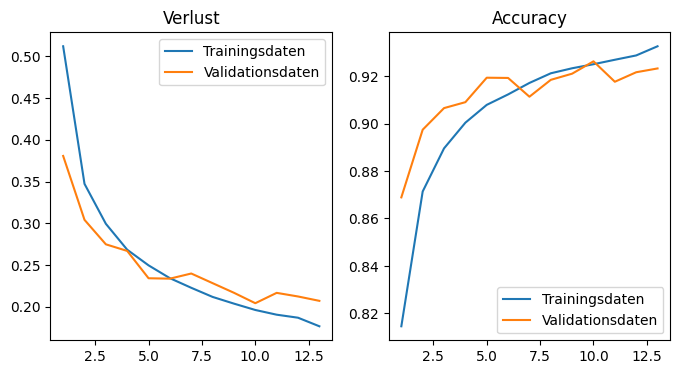
)

## FNN


Wir vergleichen hier noch einmal mit einer Variante des FNNs aus dem letzten Notebook, bei der Dropout-Schichten und Early Stopping verwendet wurden. Wir reduzieren aber die Dropout-Wahrscheinlichkeit auf 0.1, das scheint für diese Daten eine etwas bessere Accuracy zu ergeben:

In [ ]:
set_random_state(myseed)

tf.keras.backend.clear_session()

model_fnn_early_dropout = tf.keras.models.Sequential(
    [
       tf.keras.layers.Flatten(input_shape=(28,28)),
       tf.keras.layers.Dense(500, activation="relu"),
       tf.keras.layers.Dropout(0.1),
       tf.keras.layers.Dense(300, activation="relu"),
       tf.keras.layers.Dropout(0.1),
       tf.keras.layers.Dense(200, activation="relu"),
       tf.keras.layers.Dropout(0.1),
       tf.keras.layers.Dense(100, activation="relu"),
       tf.keras.layers.Dropout(0.1),
       tf.keras.layers.Dense(50, activation="relu"),
       tf.keras.layers.Dropout(0.1),
       tf.keras.layers.Dense(10, activation="softmax")
       ]
    )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Details zum Training: wie soll optimiert und ausgewertet werden?
model_fnn_early_dropout.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history_fnn_early_dropout = model_fnn_early_dropout.fit(X_train, y_train, epochs=40,callbacks=[callback],validation_data=(X_valid, y_valid))

In [ ]:
model_fnn_early_dropout.evaluate(X_valid,y_valid)

In [ ]:
plot_valid(history_fnn_early_dropout)

Ein Modell mit dieser Konfiguration erreicht normalerweise eine um ca. 3% schlechtere Accuracy als das CNN oben. Die Grafik unten zeigt einen Durchlauf, bei dem das beste Modell 89.06% erreichte. Das Training brach nach 12 Epochen ab, das beste Modell war das in Epoche 9. Das Training dauerte auf Google Colab unter Nutzung der CPU ca. 4 Minuten, mit etwa 20 Sekunden pro Epoche.

Das FNN ist also etwas schlechter, ist dafür aber schneller trainiert - bei diesem Beispieldurchlauf in ca. einem Drittel der Zeit. Das liegt daran, dass das Training der Filterkerne im CNN so aufwendig ist. Die Filterkerne ergeben zwar in der Summe deutlich weniger Gewichte als voll miteinander verbundene Schichten, weil die Gewichte eines Filterkerns jeweils von mehreren Neuronen geteilt werden. Das Training dieser geteilten Gewichte ist aber aufwendiger.



![model_fnn_early_dropout.png](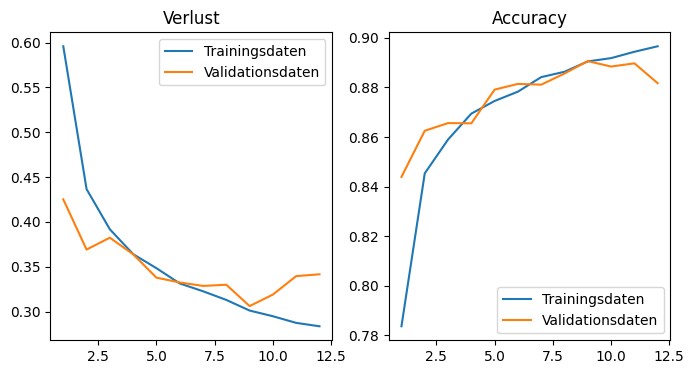
)

Was ist also überhaupt der Vorteil des CNN, abgesehen von der höheren Accuracy, die man sich sozusagen durch Trainingszeit erkaufen muss? Ist diese Trainingszeit die 3% Accuracy wert?


# Robustheit auf leicht veränderten Daten

Um die Vorteile von CNNs besser zu verstehen, stellen Sie sich vor, Sie nutzen solche Modelle, um Waren einzusortieren - die Waren kommen auf einem Transportband an, werden von der Kamera erfasst, und mithilfe des Modells kategorisiert und dann in Kartons sortiert. Ihr neues Transportsystem justiert die Waren aber nicht mehr perfekt, sondern verdreht die Waren beim Auflegen um bis zu 2 Grad. Funktioniert Ihre Sortierung trotzdem noch?

Wir simulieren diese Situation, indem wir die Bilder in den Validierungsdaten (zufällig) um bis zu ca. 2 Grad verdrehen.


## Bilder rotieren



Keras bietet Schichten an, die Bilder auf zufällige Weise manipulieren - wir werden später noch sehen, wofür sie üblicherweise genutzt werden.

Um eine solche Schicht für die Manipulation unserer Daten nutzen zu können, legen wir ein Modell an. Es handelt sich dabei nicht um ein Modell, das trainiert werden muss - wir wollen lediglich die in Keras implementierten Schichten zur Bildmanipulation verwenden. Das Modell wir nie trainiert (es enthält gar keine trainierbaren Parameter), sondern nur auf die Trainingsdaten angewendet, um variablere Trainingsdaten zu generieren.

Wir definieren also ein Modell, das unsere Daten einliest und dann mit einer RandomRotation-Schicht zufällig um bis zu ca. 2 Grad nach links oder rechts verdreht. Das erreichen wir durch die Angabe des Parameters 0.03 bei der RandomRotation - Keras misst Winkel mit dem sogenannten Bogenmaß, bei dem 360 Grad einem Werte von 2 Pi (ca. 6.28) entsprechen. In diesem Maß entspricht der unten vorgeschlagene Wert von 0.03 einem Winkel von etwa 2 Grad. Das zweite Argument, fill_mode="constant", bewirkt, dass fehlende Pixel ggf. mit weiß aufgefüllt werden.

Da die RandomRotation-Schicht ebenso wie die 2D-Filterkerne in CNN oben 3 Dimensionen erwarten, schalten wir eine Schicht vor, die auf (28,28,1) umformt - aber zum Abschluss lassen wir diese Dimension wieder weg, damit wir die manipulierten Bilder mit der üblichen Plot-Funktion ansehen können - daher die erneute Umformung auf (28,28).

In [ ]:
set_random_state(myseed)

data_rotation = tf.keras.Sequential([
  tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),
  tf.keras.layers.RandomRotation(0.03, fill_mode="constant"),
  tf.keras.layers.Reshape((28,28))
])

rotated_train_images = data_rotation(X_train)
rotated_valid_images = data_rotation(X_valid)


Die Original-Validierungsdaten vor dem Umformen sehen so aus:

In [ ]:
plt.figure()

# eine Reihe mit 4 Bildern
figure, panel = plt.subplots(1,4)

# Offset, um ggf. Bilder ab einem bestimmten Index anzuzeigen
offset=14

# die ersten vier Bilder in je einem Panel der Grafik anzeigen
for i in range(4):
    # Bild anzeigen
    panel[i].imshow(X_valid[i+offset], cmap="binary")
    panel[i].title.set_text(kleidungsarten[y_valid[i+offset]])

Die minimal rotierten Daten sehen so aus:

In [ ]:
plt.figure()

# eine Reihe mit 4 Bildern
figure, panel = plt.subplots(1,4)

for i in range(4):
    # Bild anzeigen
    panel[i].imshow(rotated_valid_images[i+offset], cmap="binary")
    panel[i].title.set_text(kleidungsarten[y_valid[i+offset]])

## FNN

Jetzt probieren wir aus, wie gut das FNN die leicht verdrehten Daten erkennt. Bitte beachten Sie, dass wir **nicht** auf diesen verdrehten Daten trainiert haben. Wir geben dem auf den perfekt justierten Daten trainierten Modell lediglich die neu erzeugten verdrehten Validierungsdaten.

In [ ]:
model_fnn_early_dropout.evaluate(rotated_valid_images,y_valid)


Beim Entwickeln dieses Notebooks ergab sich für das FNN auf den manipulierten Daten nur noch eine Accuracy von 82.59%. Auf den perfekt justierten Daten dagegen erreichte es 89.06% Accuracy. Es ist also um 6.5% schlechter als auf den perfekt justierten Bildern. (Und selbst auf den verdrehten Trainingsdaten, die es im Training in der nicht verdrehten Version gesehen hatte, kam es nur noch auf 84.07%... XXX Probieren Sie aus, wie sich Ihr Modell auf den verdrehten Trainingsdaten bewährt - verändern Sie dafür den Befehl oben, so dass statt der Validationsdaten die Trainingsdaten evaluiert werden.)

## CNN

Beim CNN ist der Verlust weniger dramatisch:

In [ ]:
model_cnn.evaluate(rotated_valid_images,y_valid)

Das oben verwendete CNN verliert auf den leicht rotierten Daten erfahrungsgemäß ca. 3% Accuracy. Bei der Entwicklung dieses Notebooks zum Beispiel verschlechterte es sich von 92.62% auf nun 89.75%.

Auf den weniger perfekten leicht rotierten Daten ist die Differenz in der Accuracy zwischen CNN und FFN also deutlicher als oben - statt 3% haben wir nun einen Unterschied von ca. 7%.  

Das CNN scheint also robuster gegenüber leichter Veränderungen in den Inputdaten zu sein.


## Diskussion

Das FNN ist auf den perfekt justierten Bildern gar nicht so schlecht, weil die Daten so regelmäßig sind: alle Schuhe zeigen mit der Spitze in der gleichen Richtung, alle Kleidungsstücke sind zentriert und perfekt ausgerichtet. Alle Kleidungsstücke sind noch dazu in ähnlicher Größe abgebildet, decken also immer ungefähr denselben Bereich des Bilds ab. Dadurch reicht es, dass das FNN lernt, welche Bereiche in den Bildern bei welcher Kleidungskategorie dunkel sein müssen, und welche hell sein müssen. Es lernt aber nicht wirklich die Formen kennen. Das CNN dagegen lernt Muster - die Filterkerne der ersten Schichten reagieren typischerweise auf einfache Muster wie Kanten oder Spitzen; Filterkerne höherer Schichten reagieren dann auf Kombinationen solcher Muster, die komplexere Formen ergeben.

In einer realistischen Bilderkennungsanwendung hat man selten so ideale Bilder wie die perfekt justierten Kleidungsstücke. Statt dessen haben Objekte häufig unterschiedliche Größen, stehen schief, sind geneigt, gespiegelt, usw. Einfach gesagt, sie weisen mehr Variation auf als die hier vorliegenden Daten. Im nächsten Abschnitt simulieren wir diese Situation daher durch weitere Operationen: wir drehen, zoomen und spiegeln die Bilder.

Natürlich wird damit die Performanz der auf den Originaldaten trainierten Modelle viel schlechter werden. Daher trainieren wir die Modelle auf den variableren Daten neu.

# Variablere Daten

Wir verwenden eine Schicht, die die Bilder zufällig spiegelt, drehen die Bilder um einen zufälligen Winkel von bis zu fast 6 Grad (bis zu 0.1 im Bogenmaß) und zoomen außerdem mit einem Faktor von bis zu 0.1.

Um diese Schicht ausführen zu können, legen wir wieder ein Modell an. Auch dieses Mal wird es nicht trainiert, sondern nur auf die Trainingsdaten angewendet, um neue Trainingsdaten zu generieren.

Wir nennen das Modell `data_augmentation`. *Augmentation* ist Englisch und heißt *Vermehrung*, und tatsächlich werden solche Schichten normalerweise genau dafür eingesetzt: um die Trainingsdaten zu vermehren. Denn durch mehrfache Anwendung dieser Schichten kann man im Prinzip beliebig viele Trainingsdaten erzeugen: das Spiegelbild eines Stiefels taugt als Trainingsmaterial ebenso gut wie das Original, stellt aber für ein Neuronales Netz ein neues, unbekanntes Bild dar.

Wir beginnen damit, zunächst lediglich die Trainingsdaten zu verändern, behalten aber die bisherige Menge bei: wir ersetzen also die perfekt justierten Bilder durch ihre manipulierten Entsprechungen. Mir machen also momentan noch keine "Vermehrung" von Daten.

In [ ]:
set_random_state(myseed)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1, fill_mode="constant"), # ohne "constant" kommt was komisches raus, weil es über die Bildränder hinaus reflektiert
  tf.keras.layers.RandomZoom(0.1, fill_mode="constant"),
  tf.keras.layers.Reshape((28,28))
])

augmented_train_images = data_augmentation(X_train)
augmented_valid_images = data_augmentation(X_valid)

## FNN

Wir trainieren das FNN nun auf den variableren Daten:

In [ ]:
set_random_state(myseed)
tf.keras.backend.clear_session()

model_fnn_augmented = tf.keras.models.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(500, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation="softmax")
        ]
    )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Details zum Training: wie soll optimiert und ausgewertet werden?
model_fnn_augmented.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history_fnn_augmented = model_fnn_augmented.fit(augmented_train_images, y_train, epochs=40,callbacks=[callback],validation_data=(augmented_valid_images, y_valid))

In [ ]:
plot_valid(history_fnn_augmented)

In [ ]:
model_fnn_augmented.evaluate(augmented_valid_images,y_valid)


Hier sieht man, dass das FNN Schwierigkeiten hat, mit der größeren Variabilität in den Daten umzugehen. Das Beispiel-Modell hier z.B. erreichte lediglich 77.86% Accuracy auf den Validierungsdaten. Zum Vergleich: auf den Originaldaten erreichte es 89.06%, also ca. 11% mehr.

Zum Vergleich mit Ihrem Modell ist hier wieder der Verlauf des Trainings des Beispiel-Modells. Es brach nach 10 Epochen ab, das Training dauerte auf Google Colab nur ca. 3 Minuten.

![model_fnn_augmented.png](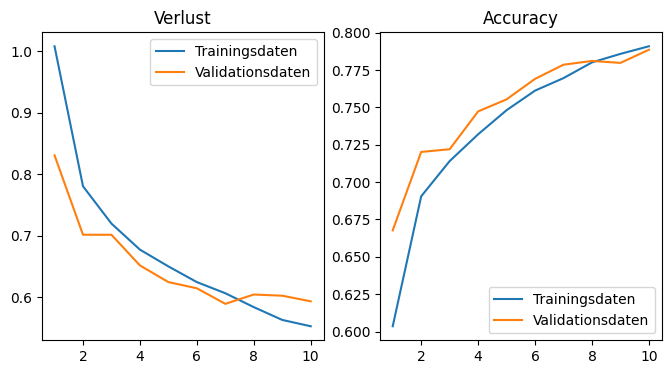
)

## CNN

In [ ]:
tf.keras.backend.clear_session()
set_random_state(myseed)

model_cnn_augmented = tf.keras.models.Sequential(
    [
        tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

model_cnn_augmented.summary() # Einen Überblick ausgeben lassen

model_cnn_augmented.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn_augmented = model_cnn_augmented.fit(augmented_train_images, y_train, epochs=40,callbacks=[callback],validation_data=(augmented_valid_images, y_valid))

In [ ]:
plot_valid(history_cnn_augmented)

In [ ]:
model_cnn_augmented.evaluate(augmented_valid_images,y_valid)


Man kan hier erkennen, dass auch das CNN nun deutlich schlechter abschneidet als vorher. Allerdings ist es nicht um so viel schlechter. Im Beispieldurchlauf bei der Entwicklung dieses Notebooks zum Beispiel erreichte das Modell statt bisher 92.62% nun nur noch 86.89% - es hat also knapp 6% Accuracy verloren. Das FNN dagegen hatte ca. 11% verloren. Insgesamt ergibt sich nun auf den schwierigeren Daten eine Differenz von um die 8% zwischen beiden Modellen - der Vorsprung des CNN ist also sehr deutlich.

Interessant ist vielleicht, dass das Training dieses Mal über mehr Epochen ging - statt nur über 13 Epochen wurde beim Beispieldurchlauf unten über 21 Epochen trainiert, das Modell konnte dieses Mal also länger lernen. Das Training dauerte entsprechend auch länger: in diesem Durchlauf 22 Minuten.


![model_cnn_augmented.png](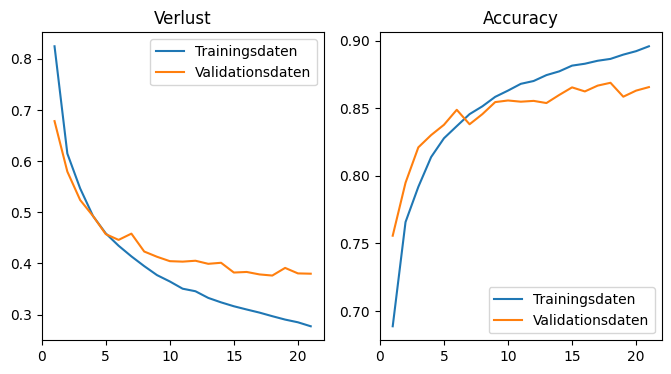
)


Im Vergleich zum FNN ist hier aber noch deutliches Overfitting zu erkennen: das Modell hat noch "Luft nach oben", die Accuracys auf Trainings- und Validierungsdaten klaffen immer weiter auseinander.

Die übliche Lösung zur Vermeidung von Overfitting ist (neben Maßnahmen wie Dropout-Schichten, die wir ja bereits verwenden), mehr Daten zum Training zu verwenden. (Dies ist natürlich nicht immer möglich, und in diesem Fällen muss man auf andere Techniken zurückgreifen, siehe dazu z.B. das Notebook zum Thema FNNs und Overfitting.)

Hier allerdings können wir sehr leicht an mehr Trainingsdaten kommen. Wie das funktioniert, erklärt der nächste Abschnitt.



# Augmentation-Schichten

Um mehr Trainingsdaten zu bekommen, verwenden wir die oben schon angesprochene Technik, die Daten zu "vermehren". Aber statt die entsprechenden Manipulationen vorher auf die Trainingsdaten anzuwenden, gehen wir diesmal so vor, dass wir diese Schichten direkt in das zu trainierende Modell einbauen. Die Idee ist, beim Training in jeder Epoche sozusagen "neue" Trainingsdaten zu erzeugen, indem man zwar die Original-Bilder einliest, sie aber zu Beginn jeder Epoche auf neue Weise durch die RandomRotation-, RandomFlip-, und RandomZoom-Schichten verändert.

## FNN



Unten sehen Sie ein FNN, das diese Schichten direkt integriert hat.

Wir lassen das Training diesmal bis zu 100 Epochen lang laufen - durch die Augmentation-Schichten haben wir genügend Material, um darauf zu hoffen, dass das Modell lange lernt. Wir setzen auch den `patience`-Parameter für das Early Stopping etwas großzügiger, um dem Modell die Chance zu geben, sich doch noch einmal zu verbessern.

Was die Evaluierung angeht, geben wir dieses Mal die oben bereits manipulierten Validierungsdaten `augmented_valid_images` an statt der Original-Daten in `X_valid`. Der Grund dafür ist, dass Keras beim Evaluieren von Modellen solche Augmentation-Schichten ignoriert. Gibt man also einfach `X_valid` als Validierungsdaten an, würde das Modell immer auf den perfekt justierten Bildern getestet.

Da wir uns hier aber konkret dafür interessieren, ob das Modell auch mit nicht perfekt justierten Bildern umgehen kann, geben wir einfach die von uns oben gespeicherten manipulierten Daten als Validierungsdaten an.

In [ ]:
set_random_state(myseed)

tf.keras.backend.clear_session()

model_fnn_augmented_longer = tf.keras.models.Sequential(
    [
        tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),

        tf.keras.layers.RandomFlip("horizontal_and_vertical",input_shape=(28, 28,1)),
        tf.keras.layers.RandomRotation(0.1, fill_mode="constant"),
        tf.keras.layers.RandomZoom(0.1, fill_mode="constant"),

        tf.keras.layers.Reshape((28,28)),

        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(500, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(200, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(50, activation="relu"),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(10, activation="softmax")

  ])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Details zum Training: wie soll optimiert und ausgewertet werden?
model_fnn_augmented_longer.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

history_fnn_augmented_longer = model_fnn_augmented_longer.fit(X_train, y_train, epochs=100,callbacks=[callback],validation_data=(augmented_valid_images, y_valid))

In [ ]:
model_fnn_augmented_longer.evaluate(augmented_valid_images, y_valid)

In [ ]:
plot_valid(history_fnn_augmented_longer)

Durch die Augmentationsschichten und das längere Training sollte man auch mit dem FNN auf ca. 83% Accuracy kommen. Und es sollte kein Overfitting passieren: die Accuracy auf den Validierungsdaten und die Accuracy auf den Trainingsdaten entwickeln sich nicht auseinander.

Im Beispieldurchlauf unten ergab sich eine Accuracy von 83.31%, bei einer Trainingsdauer von 18 Minuten auf Google Colab. 

Was hier allerdings zum ersten Mal sehr deutlich auffällt, ist der Effekt des Dropouts auf die Accuracy im Training: Die Validierungs-Accuracy liegt hier immer oberhalb der Trainings-Accuracy. Der Effekt kommt daher, dass beim Evaluieren des Modells die Dropout-Schichten nicht verwendet werden. Das heißt, bei der Evaluierung darf das Modell alle Werte nutzen, auch wenn beim Training durch Dropout regelmäßig Werte verloren gingen. Dadurch sind die Validierungsdaten sozusagen etwas "leichter" für solche Dropout-Modelle. Oder anders ausgedrückt: das Modell wird bei der Evaluierung im Gegensatz zum Training nicht durch Dropout "behindert". Das ergibt die hier um ca. 1-2% höhere Accuracy auf den Validierungsdaten.

Dies gilt übrigens ebenso für die bisher gesehenen Modelle. Dort fiel der Effekt nur nicht auf, weil durch Overfitting die Trainingsdaten so viel besser gelernt wurden, dass der Verlust durch Dropout ausgeglichen wurde. 

Man kann überprüfen, dass auch auf den Trainingsdaten bei der Evaluierung höhere Accuracys erreicht werden als im Training, im Beispieldurchlauf z.B. 83.99%, also praktisch genauso hoch wie die Accuracy von 83.31% auf den Validierungsdaten. Überprüfen Sie das für Ihr Modell:

In [ ]:
model_fnn_augmented_longer.evaluate(X_train, y_train)

![model_fnn_augmented_longer.png](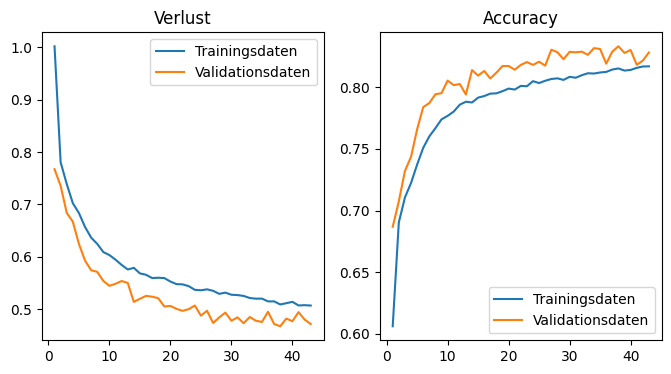
)

## CNN

In [ ]:
set_random_state(myseed)
tf.keras.backend.clear_session()

model_cnn_augmented_longer = tf.keras.models.Sequential(
    [
        tf.keras.layers.Reshape((28,28,1), input_shape=(28,28)),

        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.1, fill_mode="constant"),
        tf.keras.layers.RandomZoom(0.1, fill_mode="constant"),

        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.Conv2D(16, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

model_cnn_augmented_longer.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_cnn_augmented_longer = model_cnn_augmented_longer.fit(X_train, y_train, epochs=100,callbacks=[callback],validation_data=(augmented_valid_images, y_valid))

In [ ]:
model_cnn_augmented_longer.evaluate(augmented_valid_images, y_valid)

Das CNN kommt mithilfe der Data Augmentation nun auf um die 89% Accuracy auf den schwierigeren Daten. Das sind um die 6% mehr als das FNN. Im Beispieldurchlauf bei der Entwicklung dieses Notebooks dauerte dabei das Training aber fast eine Stunde. Es ging über 52 Epochen (und endete mit einer Accuracy von 89.36%).  Beim Training des FNNs dauerte es weniger als 20 Minuten, die ca. 83% Accuracy zu erreichen.

Den Verlauf des Beispieltrainings des CNNs sehen Sie unten.

In [ ]:
plot_valid(history_cnn_augmented_longer)

In [ ]:
model_cnn_augmented_longer.evaluate(X_valid, y_valid)

![model_cnn_augmented_longer.png](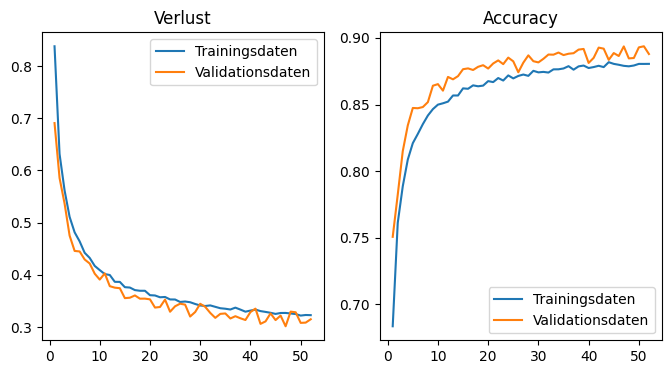
)

# Eigene Projekte

## Trainings- und Validierungsdaten selbst aus Dateien erstellen

Wenn Sie eigene Projekte mit CNNs durchführen wollen, ist es möglicherweise nötig, selbst Trainingsdaten zu erstellen. Eine recht einfache Variante hierfür ist das Laden von Bildern aus Unterverzeichnissen mittels der Funktion `tensorflow.keras.utils.image_dataset_from_directory()`.

Wir probieren das Verfahren hier an Daten aus, die Tensorflow für Bildklassifikation anbietet. Die Daten können als komprimiertes Archiv
__[hier](https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz)__ heruntergeladen werden.

Falls Sie dieses Notebook auf einem eigenen Windows-Rechner ausführen, werden die Befehle in der folgenen Zelle vermutlich nicht funktionierten. Die Befehle mit dem Ausrufezeichen sind nämlich keine python-Befehle, sondern Befehle für das Betriebssystem Linux, auf dem das Notebook bei Google Colabs läuft. Sie funktionieren deshalb nicht unbedingt, wenn Sie dieses Notebook auf Ihrem eigenen Rechner ausführen, falls Sie kein Linux verwenden. Legen Sie in diesem Fall im Verzeichnis mit diesem Notebook ein Unterverzeichnis namens `data` an und entpacken sie die heruntergeladene Datei `flower_photos.tgz` dort. Wir gehen in diesem Notebook davon aus, dass die Daten in diesem Unterverzeichnis liegen.  

Falls Sie dieses Notebook auf einem eigenen Linux-oder Mac-Rechner oder unter Google Colabs ausführen, sollten die folgenden Befehle das Laden und Auspacken aber automatisch erledigen. Achtung, Sie überschreiben eine ggf. schon existierende Datei flower_photos.tgz im Verzeichnis `data` sowie die ggf. darin schon entpackten Bilder. 

```
# Überprüfen, ob Datei schon geladen, und laden, falls nicht
![ -f data/flower_photos.tgz ] || wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz -P data
!cd data; tar xfz flower_photos.tgz
```
Sie finden diese Befehle bereits vorbereitet in der nächsten Code-Zelle. 

***Anmerkung für Nutzer*innen bei Google Colabs***

---

Falls Sie das Notebook bei Google Colabs bearbeiten, werden die Daten für die Dauer der Sitzung in einem temporären Speicher im Verzeichnis `data` gespeichert. Sie können diese Daten sehen, wenn Sie in der Seitenleiste von Google Colabs (ganz links) auf das Ordnersymbol klicken. Dort sollten ein Verzeichnis `data` angezeigt werden, das Sie anklicken können. Sie finden darin die geladene Datei sowie das entpackte Verzeichnis `flower_photos`. In diesem Verzeichnis gibt es für 5 verschiedene Blumensorten Unterordner, die `.jpg` Bilder der jeweiligen Sorte enthalten. Diese Daten verschwinden aber, wenn Sie die Sitzung beenden. 

Wenn Sie die Daten lieber dauerhaft in Ihrem Google Drive speichern wollen, fügen Sie statt dessen eine Zelle mit folgendem Code ein:

```
from google.colab import drive
drive.mount('/content/drive')
# Überprüfen, ob Datei schon geladen, und laden, falls nicht
![ -f /content/drive/My\ Drive/Colab\ Notebooks/data/flower_photos.tgz ] || wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz -P /content/drive/My\ Drive/Colab\ Notebooks/data
!cd /content/drive/My\ Drive/Colab\ Notebooks/data; tar xfz flower_photos.tgz
```

Achtung, wenn Sie später wieder auf diese Daten zugreifen wollen, müssen Sie die ersten beiden Befehle (für den Zugriff auf Ihr Google Drive) neu ausführen. Und: die Daten liegen bei Ihnen dann **nicht** im Verzeichnis `data`. Sie müssen in Zukunft statt `data` immer `/content/drive/My\ Drive/Colab\ Notebooks/data` angeben.

---


In [ ]:
# funktioniert vermutlich nicht für Windows-Nutzer*innen, die das Notebook auf ihrem eigenen Rechner ausführen

# Überprüfen, ob Datei schon geladen, und laden, falls nicht
![ -f data/flower_photos.tgz ] || wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz -P data
!cd data; tar xfz flower_photos.tgz


Achtung, wenn Sie die oben geladenen Daten nun in Variablen einlesen, wird einiges an RAM-Speicher belegt. Bei Google Colabs können Sie hier an die Grenzen des Ihnen verfügbaren Speichers kommen. Es ist daher eine gute Idee, den durch die nicht mehr benötigten Kleider-Daten belegten RAM frei zu machen. Wir löschen daher explizit die Variablen, deren Inhalt viel Platz einnimmt:

In [ ]:
del X_test_norm, X_test_orig, X_train, X_train_norm, X_train_orig, X_valid
del augmented_train_images, augmented_valid_images
del rotated_train_images, rotated_valid_images

del model_cnn, model_cnn_augmented, model_cnn_augmented_longer, model_fnn_early_dropout, model_fnn_augmented, model_fnn_augmented_longer

## Erstellen der Daten

Sie können anschließend die Funktion `image_dataset_from_directory()` aus dem Modul `tensorflow.keras.utils` verwenden, um aus diesen Bildern einen Datensatz zu machen, der direkt zum Training verwendet werden kann. Diese Funktion sucht im angegebenen Verzeichnis nach Unterverzeichnissen. Sie nimmt an, dass die Unterverzeichnisse den Klassen entsprechen, und verwendet alle Bilder innerhalb desselben Unterverzeichnisses als Exemplare derselben Klasse. Die Funktion erzeugt ein Tensorflow-`DataSet`-Objekt, das Batches von Tensoren mit Features und den jeweiligen Klassenvektor enthält. Theoretisch kann man hierbei direkt auch angeben, dass die Daten gemischt werden sollen (`shuffle=False`). Man kann außerdem einen Validation-Split angeben, und einen Parameter, der dann entweder nur die Validierungsdaten verwendet oder nur die Trainingsdaten. Auf dieses Weise kann man durch 2 Aufrufe der Funktion direkt die Trainings- und Validierungsdaten getrennt erzeugen.

Wir verzichten hier auf die Angabe dieser Parameter, weil wir den Validation-Split in einer geeignetere Weise angehen wollen.

In [ ]:
data_dir = 'data/flower_photos'

flowers_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  shuffle=False,
  seed=myseed,
  image_size=(180,180),
  batch_size = 32)


Die Klassen der Daten finden wir anschließend im Attribut `class_names`.  

In [ ]:
flowers_dataset.class_names

Das Ergebnis des Aufrufs ist ein `DataSet`-Objekt. Unser Ziel ist es jetzt, die Daten bestmöglich in Trainings- und Validierungsdaten aufzuteilen.


## Zugriff auf DataSet-Objekt und neue Aufteilung


Leider ist es etwas kompliziert, auf den Inhalt von Dataset-Objekten, d.h. auf die Features und die Klassen, getrennt zuzugreifen. Das liegt daran, dass es sich bei solchen Datasets eigentlich um Listen von Elementen handelt, die jeweils aus Features und Klassenvektor bestehen. Der Hintergrund ist, dass das Dataset-Objekt hier selbst bestimmt, in welchen "Happen" die Daten verarbeitet werden: die Daten sind, ideal für das Training von Modellen, bereits in Batches unterteilt. Wir haben es also nicht mehr mit einem Tensor für die Features und einem Vektor für die Klassen zu tun, sondern mit einer Liste von Batches mit potentiell vielen Tensoren und Klassenvektoren.

Wir müssen daher einen großen Tensor für alle Features und den Vektor mit allen Klassen von Hand erzeugen. Dies geschieht, indem wir einmal durch alle Paare von Features und Labels gehen, im Code unten ausgedrückt als: `for x, y in flowers_dataset`. Für alle diese Paare behalten wir nur das `x`, also die Features, und machen daraus eine Liste: `[x for x, y in flowers_dataset]`. Und die Elemente dieser Liste fügen wir anschließend mit `np.concatenate` zu einem Tensor für die Features zusammen. Ebenso verfahren wir ein zweites Mal, behalten dabei aber nur die Labels. Danach haben wir die Daten in dem uns bisher bekannten Format.

In [ ]:
X_flowers_all = np.concatenate([x for x, y in flowers_dataset], axis=0)
y_flowers_all = np.concatenate([y for x, y in flowers_dataset], axis=0)

# nicht mehr benötigte Daten löschen, um RAM zu sparen
del flowers_dataset

Wir können uns nun die Klassenverteilung in den Gesamtdaten ansehen, indem wir ein Histogramm anzeigen lassen:

In [ ]:
plt.hist(y_flowers_all, bins=5)
plt.show()

Hier ist gut zu sehen, dass die Verteilung ungleich ist: es gibt nicht von allen Klassen gleich viele Bilder. Dies bedeutet aber, dass die Verteilung in den Validierungs- und Trainingsdaten ebenso ungleich ist. Wenn man sie einfach nur durch Zufall erledigen lässt, indem man oben beim Einlesen der Daten einen Validation-Split angibt, riskiert man, dass die Verteilung sogar (per Zufall) noch ungleicher ist.

In unserem Fall ist es so, dass jede Klasse mindestens 630 Bilder enthält. Wir lösen das Problem daher, indem wir aus unseren Gesamtdaten von jeder Klasse nur 630 Bilder behalten. Dafür wählen wir für jede der 5 Klassen mithilfe von `np.where` genau die Datenpunkte aus dem Klassenvektor aus, deren Klasse die gewünschte ist. Davon ziehen wir per Zufall genau 630 (`np.random.choice`). Wir merken uns nur die Indizes dieser Datenpunkte und kombinieren mit `np.concatenate` die Ergebnisse für die einzelnen Batches am Ende wieder. Dadurch haben wir am Ende in `balanced_indices` die Indizes von genau 630 zufällig ausgewählten Exemplaren jeder Klasse.

Diese Indizes werden als Float-Zahlen erzeugt. Um damit anschließend den Gesamt-Tensor und den Klassenvektor indizieren zu können, wandeln wir ihn vorher noch in Integers um.

In [ ]:
set_random_state(myseed)

# ein leeres Array vorbereiten, in dem anschließend die Indizes gesammelt werden
balanced_indices = np.array([])

# über die Klassen 0-4 iterieren
for i in range(5):
  # Indizes aller Exemplare der Klasse
  indices = np.where(y_flowers_all==i)[0]
  # daraus 630 zufällig auswählen und in das Array schreiben
  balanced_indices = np.concatenate((np.random.choice(indices, size=630, replace=False), balanced_indices))

# Indizes in integer umwandeln
balanced_indices=balanced_indices.astype(int)

# ausgewogene Daten mithilfe der Indizes extrahieren
y_flowers_balanced=y_flowers_all[balanced_indices]
X_flowers_balanced=X_flowers_all[balanced_indices]

In [ ]:
# Platz freigeben
del X_flowers_all

Nun haben wir also ausgewogene Daten. Wir können nun sinnvoll in Trainings- und Validierungsdaten aufteilen. Durch Angabe von `stratify=y_flowers_balanced` können wir sicherstellen, dass die aufgeteilten Daten immer noch ausgewogen sind.

In [ ]:
X_flowers_train, X_flowers_valid, y_flowers_train, y_flowers_valid = train_test_split(X_flowers_balanced, y_flowers_balanced, test_size=700, stratify=y_flowers_balanced, random_state=143)

In [ ]:
# Gesamtdaten können nach Aufteilung gelöscht werden, um RAM zu sparen
del X_flowers_balanced


Wir werfen nun einen Blick auf die Daten. Der Vektor mit den englischen Klassennamen wurde hier von Hand übersetzt. Wir hatten die Originalklassen (per `flowers_dataset.class_names`) oben bereits einmal ausgegeben. 

In [ ]:
# ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
blumen = ['Gänseblümchen', 'Löwenzahn', 'Rosen', 'Sonnenblumen', 'Tulpen']

plt.figure()

# eine Reihe mit 4 Bildern
figure, panel = plt.subplots(1,4)

# Offset, um ggf. Bilder ab einem bestimmten Index anzuzeigen
offset=4

# die ersten vier Bilder in je einem Panel der Grafik anzeigen
for i in range(4):
    # Bild anzeigen
    panel[i].imshow(X_flowers_train[i+offset].astype("uint8"))
    # Titel ergänzen: y_train_orig[i+offset] ergibt die Klasse, z.B. 9
    # dann entsprechendes Element aus kleidungsarten als Titel nehmen:
    # kleidungsarten[9] ergibt Stiefel
    panel[i].title.set_text(blumen[y_flowers_train[i+offset]])

Danach könnten Sie Ihr Modell wie gewohnt trainieren. Achtung, die Blumen-Bilder sind mit 180x180 Pixeln deutlich größer als die Kleider-Bilder mit 28x28 Pixeln. Dadurch wird das Modelltraining sehr viel langwieriger und speicherintensiver. Reduzieren Sie ggf. die Modellkomplexität, indem Sie Schichten eliminieren und das Training zumindest bei den ersten Versuchen auf weniger Epochen beschränken. 

Erwarten Sie außerdem deutlich niedrigere Accuracys - die Daten sind komplexer und nicht so "sauber" wie die Kleiderdaten, mit denen wir bisher zu tun hatten. 

Achtung, auch dieses Mal sind die Pixelwerte der Daten im Bereich von 0 bis 255. Sie sollten daher unbedingt die Daten normalisieren (sie auf Werte zwischen 0 und 1 bringen). 

Dies kann man statt vor dem Training auch innerhalb des Modells erledigen: Sie brauchen dann als erste Schicht eine Schicht `tf.keras.layers.Rescaling(1./255)`, die die Skalierung erledigt. Da es sich um die erste Schicht im Modell handelt, müssen Sie außerdem noch die Form des Inputs als Argument mitgeben, also `tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3))`. Falls Sie sich für diese Lösung entscheiden, muss das entsprechende `input_shape`-Argument aus der darauffolgenden Schicht natürlich entfernt werden. 

Alternativ können Sie vorher aber auch die Daten durch 255 teilen und speichern, so, wie wir es bisher auch schon gehandhabt haben. Bitte nicht vergessen, dass das auch für die Validierungsdaten gilt. 